input : 5 * 128 * 128 * 1

In [1]:
import dicom
import inspect
import pylab
import numpy as np
from glob import glob
import os

import matplotlib
import matplotlib.pyplot as plt

import keras
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

from utils.data_manager import load_patient, normalize, Patient, data_generator
from model.shifting_sandwich import shifting_sandwich_model_3d_conv

from skimage import measure
from scipy import ndimage

import math
from sys import stdout

/usr/local/lib/python3.5/dist-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)
Using TensorFlow backend.


In [2]:
baseDir = 'shifting_sandwich'

In [3]:
benign = glob('slimdata/benign*')
malign = glob('slimdata/malign*')
np.random.shuffle(benign)
np.random.shuffle(malign)

b_train = benign[:62]
m_train = malign[:220]

b_valid = benign[62:]
m_valid = malign[220:]

In [121]:
benign_gen = data_generator(b_train, nodule_ratio=0.7, hand_size=16, get_size=2, get_num=50, turnover=8)
malign_gen = data_generator(m_train, nodule_ratio=0.5, hand_size=16, get_size=1, get_num=50, turnover=8)
bv_gen = data_generator(b_valid, nodule_ratio=0.5, hand_size=8, get_size=8, get_num=4, turnover=2)
mv_gen = data_generator(m_valid, nodule_ratio=0.5, hand_size=8, get_size=8, get_num=4, turnover=2)

In [122]:
def gen_combinator(genList):
    while True:
        xx = []
        yy = []
        for gen in genList:
            X, y = next(gen)
            xx.append(X)
            yy.append(y)
        yield np.vstack(xx), np.vstack(yy)

In [123]:
train_gen = gen_combinator([benign_gen, malign_gen])
valid_gen = gen_combinator([bv_gen, mv_gen])

In [124]:
def print_validation_loss(model):
    mean_loss = None
    first_time = True
    while True:
        X, y = next(valid_gen)
        loss = model.evaluate(X, y)
        if first_time:
            mean_loss = np.array(loss)
        else:
            mean_loss = (mean_loss * 0.8) + (np.array(loss) * 0.2)
        print ('validation loss: %f\t prec: %f\trecall: %f' % tuple(mean_loss))
        yield

In [125]:
EPOCH = 30
BATCH = 20

hFile = os.path.join(baseDir,'history.npy')
history = None
if os.path.exists(hFile):
    history = list(np.load(hFile))
else:
    history = []

model = None
if len(history) == 0:
    model = shifting_sandwich_model_3d_conv()
else:
    model = load_model( baseDir + ('model%04d' % (len(history)-1)) )
    

In [126]:
validate = print_validation_loss(model)

In [127]:
model.load_weights('shifting_window_weights.h5')

In [128]:
for e in range(10):
    print ('Epoch %d' % e)
    mean_loss = np.array([0, 0, 0])
    for i in range(50):
        X, y = next(train_gen)
        loss = np.array(model.train_on_batch(X, y))
        mean_loss = mean_loss + loss
        stdout.write('\rbatch - %d ## train loss: %f\t prec: %f\t recall: %f' % tuple([i] + list(mean_loss / (i + 1))))
    print("")
    next(validate)
    model.save(baseDir + '/model%04d.h5' % e)

Epoch 0
batch - 49 ## train loss: 0.252322	 prec: 0.899476	 recall: 0.902333
16/16 [==============================] - 1s
validation loss: 3.041786	 prec: 0.470588	recall: 0.307692
Epoch 1
batch - 49 ## train loss: 0.181081	 prec: 0.926667	 recall: 0.918000
16/16 [==============================] - 1s
validation loss: 1.193927	 prec: 0.772727	recall: 0.708333
Epoch 2
batch - 49 ## train loss: 0.155024	 prec: 0.918000	 recall: 0.918333
16/16 [==============================] - 1s
validation loss: 1.969757	 prec: 0.761905	recall: 0.640000
Epoch 3
batch - 49 ## train loss: 0.271079	 prec: 0.896333	 recall: 0.889000
16/16 [==============================] - 1s
validation loss: 0.795754	 prec: 0.708333	recall: 0.739130
Epoch 4
batch - 49 ## train loss: 0.284686	 prec: 0.864143	 recall: 0.871000
16/16 [==============================] - 1s
validation loss: 0.352120	 prec: 0.785714	recall: 0.814815
Epoch 5
batch - 49 ## train loss: 0.216369	 prec: 0.910667	 recall: 0.905667
16/16 [================

In [130]:
model.save_weights('shifting_window_weights.h5')

1. 양성 92명 악성 347명 중 일정 비율을 뽑는다.
b_train, m_train, b_valid, m_valid

2. 각 환자를 각 generator 에 넣고, validation 은 완전 랜덤으로 (한사람만 뽑아서?) 디스크를 읽어서 뽑고, 양성은 turn over 를 정해서 pool을 만들어놓고 그 안에서 매번 뽑는 위치는 완벽히 랜덤으로 돌리자.

3. check_note(오답노트) 는 어느정도 트레이닝이 된 후에 다시 생각해도 그때가서 끼워넣을 수 있다.

4. 한번에 체크되는 y는 1 \* 32 \* 32 512

5. layer \* 16 \* 16 \* 4(nroi, nodule, benign, malign)에다가 


[0 0 0 1 1 1 1 1]


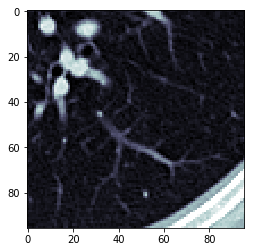

In [22]:
X, y = next(benign_gen)
print(y)
plt.imshow(X[0][1,:,:,:].reshape((96,96)), plt.cm.bone)
plt.show()

In [90]:
X, y = next(valid_gen)

print(y)
for idx, xx in enumerate(X):
    plt.subplot(2,4,idx + 1)
    plt.imshow(X[idx][1].reshape((96,96)), plt.cm.bone)
plt.show()

[[1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [0 1 0 1]
 [1 0 0 0]
 [0 1 0 1]
 [0 1 0 1]
 [1 0 0 0]
 [1 0 0 0]
 [0 0 1 1]
 [0 0 1 1]
 [0 0 1 1]
 [1 0 0 0]
 [0 0 1 1]
 [0 0 1 1]
 [0 0 1 1]]


ValueError: num must be 1 <= num <= 8, not 9

(16, 3, 96, 96, 1) (16, 4)
[0 0 0 1 1 0 0 1 0 0 0 2 0 2 0 2]
[[  1.00000000e+00   2.44117606e-13   1.22390265e-09   3.29115801e-09]
 [  9.94884789e-01   7.22119294e-04   9.78021999e-04   4.47140774e-03]
 [  9.99602020e-01   3.23029826e-06   2.08783720e-04   1.39242242e-04]
 [  1.41796845e-04   9.97025669e-01   2.66076764e-04   9.99881744e-01]
 [  4.85413665e-09   9.99969125e-01   2.25512235e-06   1.00000000e+00]
 [  9.99519229e-01   1.69728737e-05   1.10857625e-04   6.76513300e-04]
 [  9.99649644e-01   1.81635296e-05   2.63542479e-05   7.53680652e-05]
 [  2.74844410e-07   9.90511119e-01   6.84144115e-03   9.99999881e-01]
 [  6.81087911e-01   3.90288942e-02   1.35113755e-02   1.95132658e-01]
 [  9.99943495e-01   5.59313037e-07   2.54849401e-05   1.59898264e-05]
 [  5.89740666e-05   9.85551476e-01   2.89311223e-02   9.99918103e-01]
 [  9.87665772e-01   5.40852256e-04   4.57453076e-03   6.75116759e-03]
 [  6.99080467e-01   2.50636810e-03   1.22336127e-01   4.32121426e-01]
 [  1.04838738e-

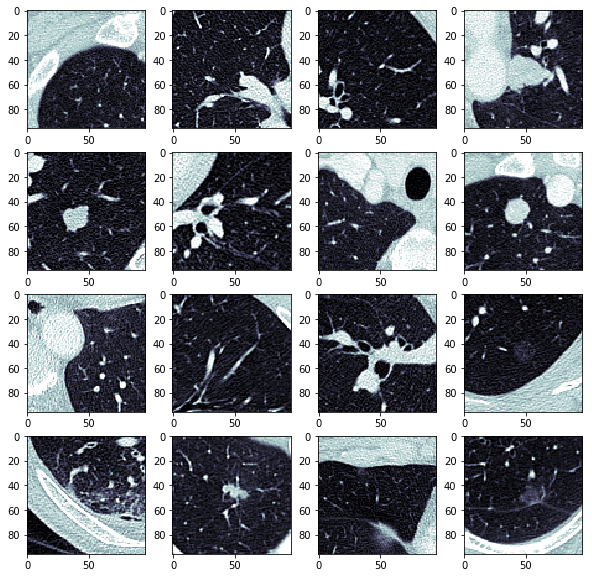

In [129]:
X, y = next(valid_gen)
print(X.shape, y.shape)

print (np.argmax(y[:,:3], axis=1))
pred = model.predict(X)
print(pred)
print (np.argmax(pred[:,:3], axis=1))

plt.figure(figsize=(10,10))
for i in range(X.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(X[i][1].reshape((96,96)), plt.cm.bone)
plt.show()